<h1 style="max-width: 900px; margin: auto; text-align: center;">
    US Dollar to Japanese Yen Rate Prediction Model
</h1>

This is an independent project by Erik Staszewski. The goal of this project is to use machine learning methods to predict the rate of the US Dollar to Japanese Yen conversion rate. This project uses a dataset of USD/JPY conversion rates from a ten-year period between 2015 and 2024.

## Data Analysis

### Load Packages and Set Device

In [1]:
# Standard Libraries
import random
import time

# Data Manipulation & Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yfinance as yf
from matplotlib.lines import Line2D

# Deep Learning
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.optimizers import Adam, Nadam

# PyTorch for Model Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn Utilities for Clustering and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### Read and Preview the Data

Obtain the data from Yahoo Finance, keeping only the Date and Close. Read it and check its dimensions; the number of rows (days) and number of columns (features).

In [54]:
# Obtain the Data from Yahoo Finance
ticker = 'JPY=X'
date_start = '2015-01-01'
date_end = '2024-12-31'

yen = yf.download(ticker, start=date_start, end=date_end, interval='1d', progress=False, auto_adjust=True)
#yen = pd.read_csv('yenrate.csv') # If Yahoo Finance doesn't work
yen = yen.reset_index()

if isinstance(yen.columns, pd.MultiIndex):
    yen.columns = yen.columns.droplevel(1)

# Keep only Date and Close
yen = yen[['Date', 'Close']]

In [56]:
print("Days:", yen.shape[0])
print("Features:", yen.shape[1])

Days: 2605
Features: 2


The dataset contains 2,605 days (10 years) with 2 features: Date, and Close. We can preview the data and check basic statistics to ensure data integrity.

In [59]:
yen

Price,Date,Close
0,2015-01-01,119.672997
1,2015-01-02,119.870003
2,2015-01-05,120.433998
3,2015-01-06,119.425003
4,2015-01-07,118.672997
...,...,...
2600,2024-12-24,157.164993
2601,2024-12-25,157.106995
2602,2024-12-26,157.132996
2603,2024-12-27,157.748001


### Plot

Plot the closing prices.

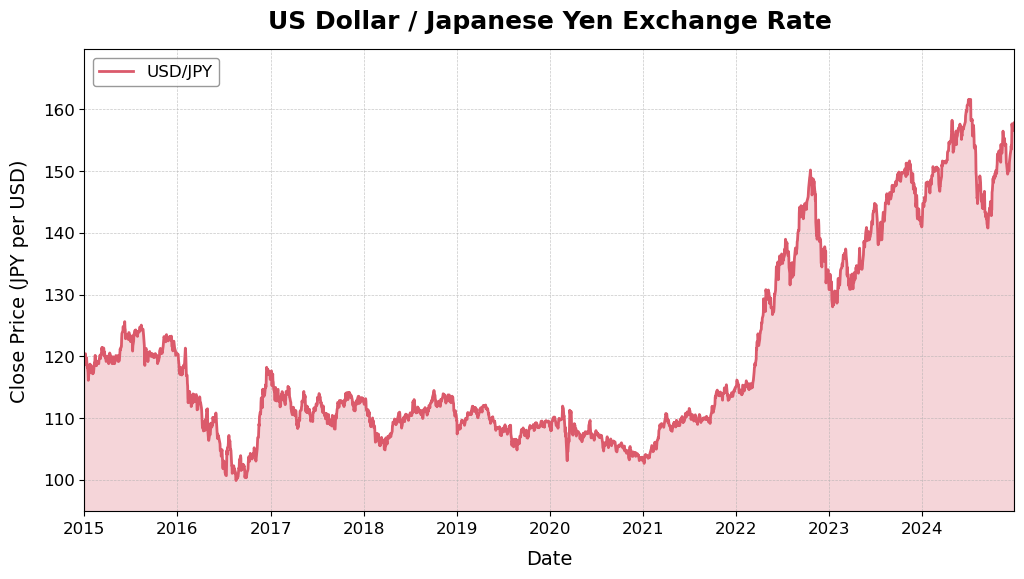

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'], yen['Close'], color='#DB5A6B', lw=2, label='USD/JPY')
plt.fill_between(yen['Date'], yen['Close'], color='#DB5A6B', alpha=0.25)
plt.title('US Dollar / Japanese Yen Exchange Rate', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Close Price (JPY per USD)', fontsize=14, labelpad=10)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.ylim(min(yen['Close']) * 0.95, max(yen['Close']) * 1.05)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray', loc='upper left')
plt.show()

### Return and Volatility

Now calculate the Return and Volatility.

In [65]:
yen['Return'] = yen['Close'].pct_change() # Returns
yen['Volatility'] = yen['Return'].rolling(window=20).std() # Rolling Volatility
yen.dropna(inplace=True) # Drop missing values
scaler = StandardScaler() # Normalize
yen[['Return', 'Volatility']] = scaler.fit_transform(yen[['Return', 'Volatility']])

In [67]:
yen

Price,Date,Close,Return,Volatility
20,2015-01-29,117.592003,-0.302332,1.139099
21,2015-01-30,118.248001,0.979178,1.195845
22,2015-02-02,117.183998,-1.639877,1.247232
23,2015-02-03,117.574997,0.576353,1.190879
24,2015-02-04,117.646004,0.085357,1.139120
...,...,...,...,...
2600,2024-12-24,157.164993,0.702267,0.925928
2601,2024-12-25,157.106995,-0.089459,0.748168
2602,2024-12-26,157.132996,0.006582,0.443002
2603,2024-12-27,157.748001,0.680078,0.430588


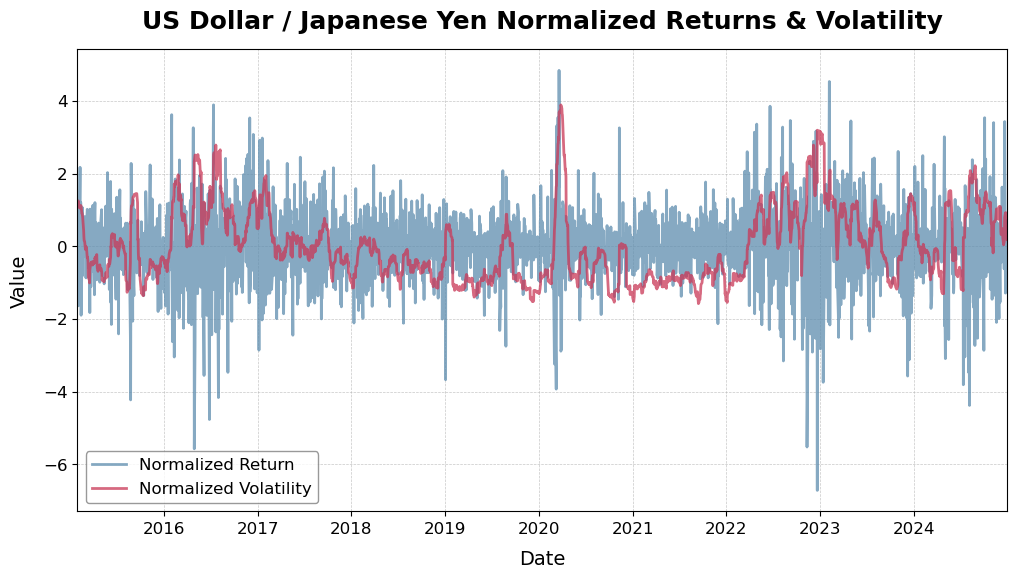

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'], yen['Return'], color='#5D8CAE', lw=2, alpha=0.75, label='Normalized Return')
plt.plot(yen['Date'], yen['Volatility'], color='#C93756', lw=2, alpha=0.75, label='Normalized Volatility')
plt.title('US Dollar / Japanese Yen Normalized Returns & Volatility', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Value', fontsize=14, labelpad=10)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray', loc='lower left')
plt.show()

## Regime Detection with K-Means Clustering

K-Means Clustering to identify market regimes. We can look at the elbow method, but we already know that we want three regimes: Stable, Bull, and Bear.

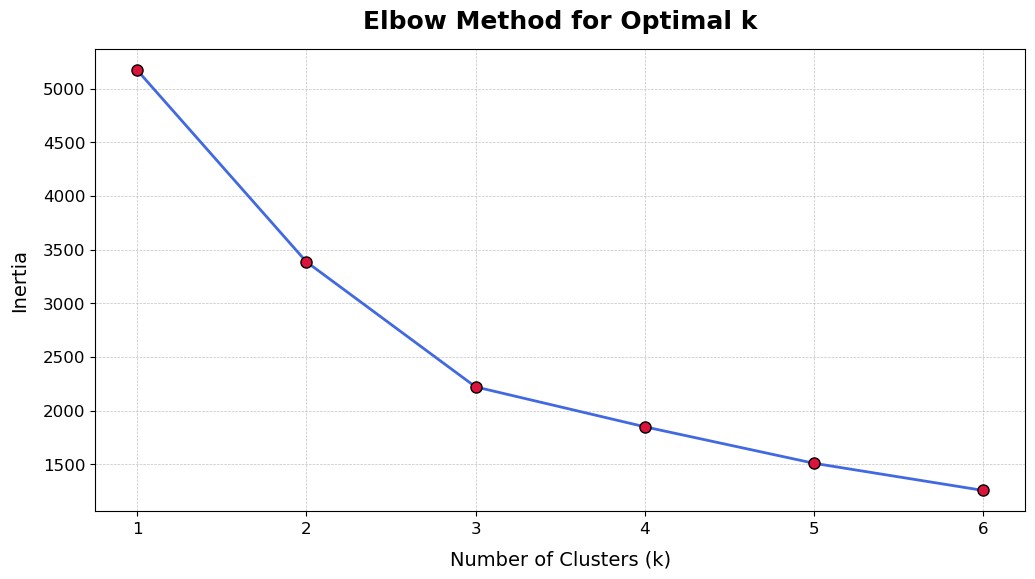

In [72]:
ks = range(1, 7)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(yen[['Return', 'Volatility']])
    inertias.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(ks, inertias, marker='o', color='royalblue', lw=2, markersize=8, markerfacecolor='crimson', markeredgecolor='black')
plt.title('Elbow Method for Optimal k', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Number of Clusters (k)', fontsize=14, labelpad=10)
plt.ylabel('Inertia', fontsize=14, labelpad=10)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.75)
plt.xticks(ks, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

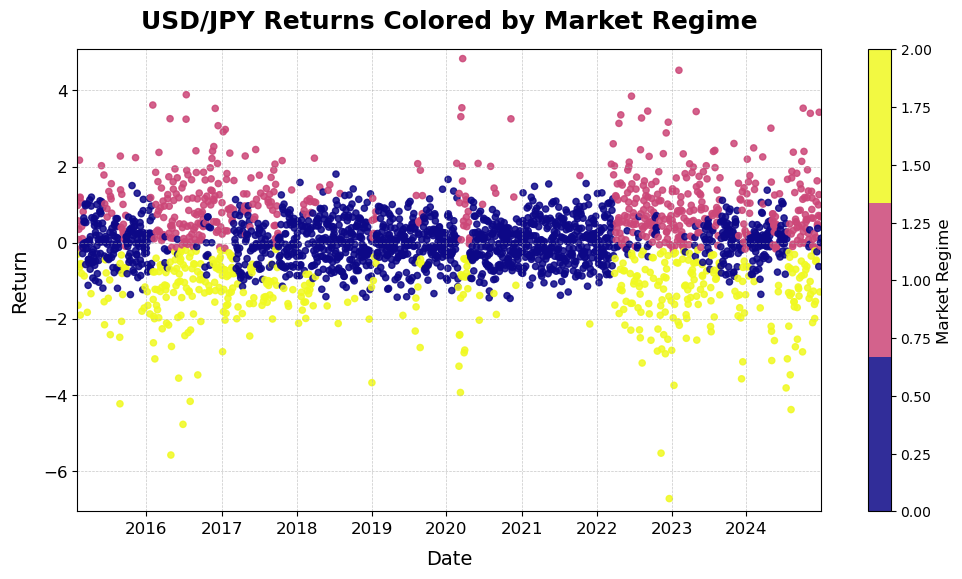

In [74]:
np.random.seed(120)

# Fit the K-Means model with the optimal number of clusters
kmeans_model = KMeans(n_clusters=3, random_state=120)
yen['K Regime'] = kmeans_model.fit_predict(yen[['Return', 'Volatility']])

# One-hot encoding of the K Regime column
one_hot = pd.get_dummies(yen['K Regime'], prefix='Regime')

# Add the one-hot encoded columns to the yen DataFrame
yen = yen.loc[:, ~yen.columns.str.startswith('Regime_')] # Remove existing columns
yen = pd.concat([yen, one_hot], axis=1)

cmap = plt.colormaps['plasma'].resampled(3)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(yen['Date'], yen['Return'], c=yen['K Regime'], cmap=cmap, s=20, alpha=0.85)
plt.title('USD/JPY Returns Colored by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Return', fontsize=14, labelpad=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Market Regime', fontsize=12)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.ylim(min(yen['Return']) * 1.05, max(yen['Return']) * 1.05)
plt.show()

In [76]:
yen

,Date,Close,Return,Volatility,K Regime,Regime_0,Regime_1,Regime_2
20,2015-01-29,117.592003,-0.302332,1.139099,2,False,False,True
21,2015-01-30,118.248001,0.979178,1.195845,1,False,True,False
22,2015-02-02,117.183998,-1.639877,1.247232,2,False,False,True
23,2015-02-03,117.574997,0.576353,1.190879,1,False,True,False
24,2015-02-04,117.646004,0.085357,1.139120,1,False,True,False
...,...,...,...,...,...,...,...,...
2600,2024-12-24,157.164993,0.702267,0.925928,1,False,True,False
2601,2024-12-25,157.106995,-0.089459,0.748168,1,False,True,False
2602,2024-12-26,157.132996,0.006582,0.443002,0,True,False,False
2603,2024-12-27,157.748001,0.680078,0.430588,1,False,True,False


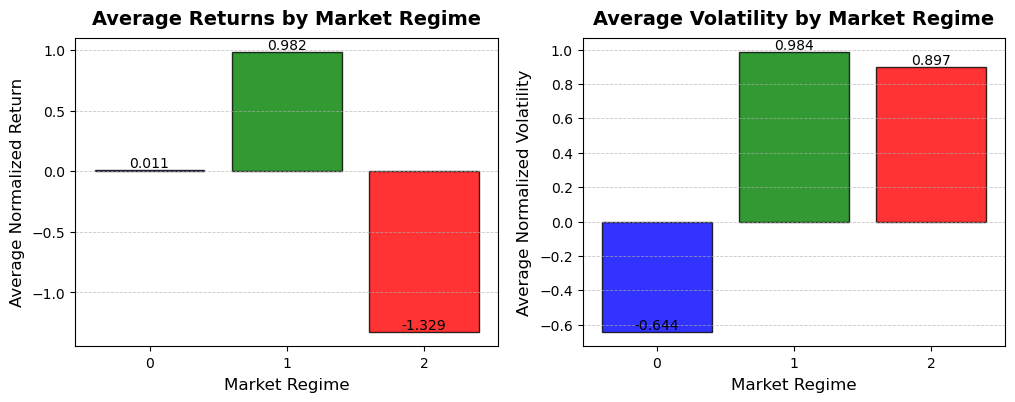

In [78]:
regime_summary = yen.groupby('K Regime').mean()[['Return', 'Volatility']]
# Define custom colors for the regimes
regime_colors = ['blue', 'green', 'red']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Average Returns by Market Regime
axes[0].set_title('Average Returns by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars1 = axes[0].bar(regime_summary.index, regime_summary['Return'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[0].set_ylabel('Average Normalized Return', fontsize=12, labelpad=5)
axes[0].grid(axis='y', linestyle='--', lw=0.6, alpha=0.7)
axes[0].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

# Plot Average Volatility by Market Regime
axes[1].set_title('Average Volatility by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars2 = axes[1].bar(regime_summary.index, regime_summary['Volatility'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[1].set_ylabel('Average Normalized Volatility', fontsize=12, labelpad=5)
axes[1].grid(axis='y', linestyle='--', lw=0.6, alpha=0.7)
axes[1].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.show()

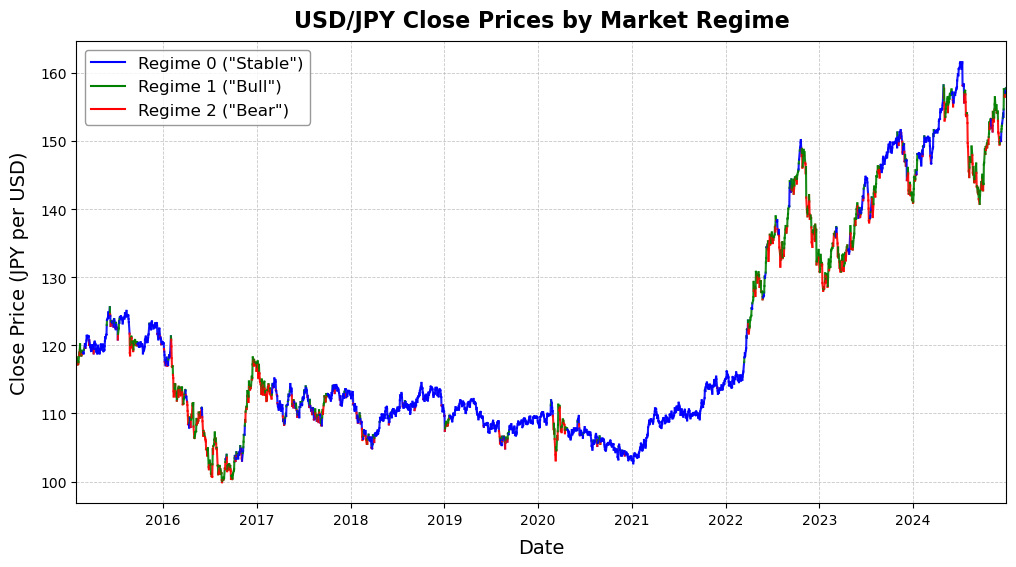

In [79]:
# Create a color map for the regimes
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))
for i in range(1, len(yen.Close.values)):
    if yen['K Regime'].values[i] != yen['K Regime'].values[i-1]:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], 
                 color=colors[yen['K Regime'].values[i-1]], lw=1.5, alpha=0.9)
    else:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], 
                 color=colors[yen['K Regime'].values[i]], lw=1.5, alpha=0.9)
plt.title('USD/JPY Close Prices by Market Regime', fontsize=16, fontweight='bold', pad=10)
plt.xlabel('Date', fontsize=14, labelpad=8)
plt.ylabel('Close Price (JPY per USD)', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.6, alpha=0.7)
legend_elements = [Line2D([0], [0], color=colors[0], lw=1.5, label='Regime 0 ("Stable")'),
                   Line2D([0], [0], color=colors[1], lw=1.5, label='Regime 1 ("Bull")'),
                   Line2D([0], [0], color=colors[2], lw=1.5, label='Regime 2 ("Bear")')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12, frameon=True, edgecolor='gray')
plt.show()

In [81]:
yen

,Date,Close,Return,Volatility,K Regime,Regime_0,Regime_1,Regime_2
20,2015-01-29,117.592003,-0.302332,1.139099,2,False,False,True
21,2015-01-30,118.248001,0.979178,1.195845,1,False,True,False
22,2015-02-02,117.183998,-1.639877,1.247232,2,False,False,True
23,2015-02-03,117.574997,0.576353,1.190879,1,False,True,False
24,2015-02-04,117.646004,0.085357,1.139120,1,False,True,False
...,...,...,...,...,...,...,...,...
2600,2024-12-24,157.164993,0.702267,0.925928,1,False,True,False
2601,2024-12-25,157.106995,-0.089459,0.748168,1,False,True,False
2602,2024-12-26,157.132996,0.006582,0.443002,0,True,False,False
2603,2024-12-27,157.748001,0.680078,0.430588,1,False,True,False


## Model

In [83]:
# Prepare data for the model
test_size = yen[yen['Date'].dt.year >= 2020].shape[0]
scaler = MinMaxScaler()

print(test_size)

1304


In [87]:
window_size = 60

# Scale the close price and regime features
train_data = yen[['Close', 'K Regime']][:-test_size]
test_data = yen[['Close', 'K Regime']][-test_size-window_size:]

train_data['Close_scaled'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close_scaled'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close_scaled'].values.reshape(-1, 1), train_data['K Regime'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close_scaled'].values.reshape(-1, 1), test_data['K Regime'].values.reshape(-1, 1)], axis=1)

train_data.size

2562

In [89]:
train_data

array([[0.68755608, 2.        ],
       [0.71305848, 1.        ],
       [0.6716946 , 2.        ],
       ...,
       [0.37460645, 0.        ],
       [0.37017468, 0.        ],
       [0.34859865, 0.        ]])

In [91]:
# Training Set
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, 0])

# Testing Set
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(train_data[0])))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(train_data[0])))

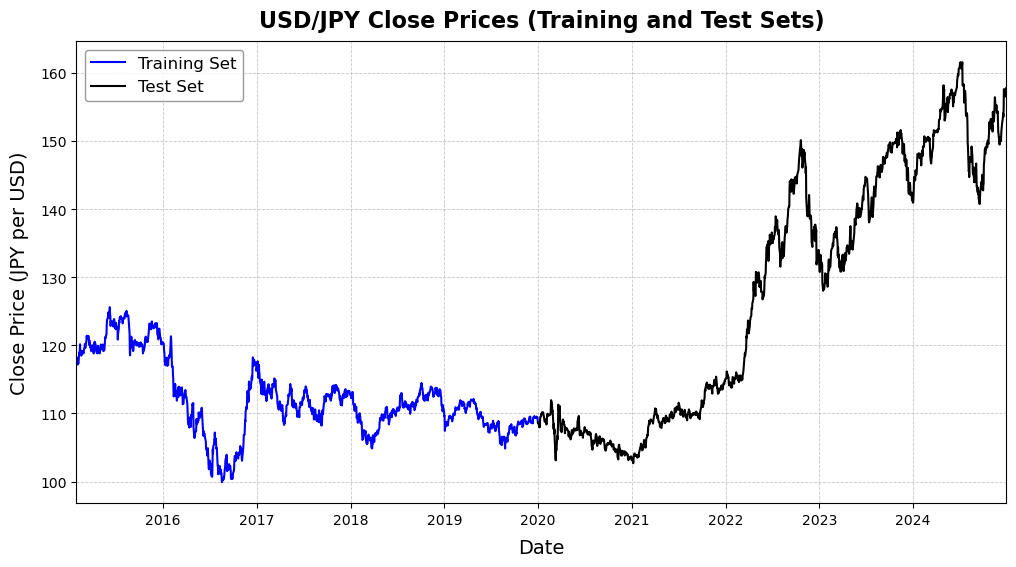

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'][:-test_size], yen.Close[:-test_size], 
         label="Training Set", color='blue', lw=1.5)
plt.plot(yen['Date'][-test_size:], yen.Close[-test_size:], 
         label="Test Set", color='black', lw=1.5)
plt.title('USD/JPY Close Prices (Training and Test Sets)', fontsize=16, fontweight='bold', pad=10)
plt.xlabel('Date', fontsize=14, labelpad=8)
plt.ylabel('Close Price (JPY per USD)', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.6, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.show()

### LSTM Model

In [138]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(X_train.shape[2], 480, 3, batch_first=True, dropout=0.2)
        self.silu = nn.SiLU() # Swish Activation
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(480, 400)
        self.fc2 = nn.Linear(400, 320)
        self.fc3 = nn.Linear(320, 240)
        self.fc4 = nn.Linear(240, 160)
        self.fc5 = nn.Linear(160, 80)
        self.fc6 = nn.Linear(80, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x) # LSTM layers
        x = x[:, -1, :] # Normalize Output
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.silu(x) # Activation
        return x

In [215]:
torch.manual_seed(120)

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10
batch_size = 50
train_losses, val_losses = [], []
epoch_times = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    end_time = time.time()
    epoch_times.append(end_time - start_time)
    
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_times[-1]:.2f} seconds')

Epoch 1, Training Loss: 0.0731, Validation Loss: 0.6579, Time: 10.24 seconds
Epoch 2, Training Loss: 0.0159, Validation Loss: 0.0564, Time: 9.12 seconds
Epoch 3, Training Loss: 0.0068, Validation Loss: 0.1180, Time: 11.92 seconds
Epoch 4, Training Loss: 0.0042, Validation Loss: 0.0472, Time: 9.86 seconds
Epoch 5, Training Loss: 0.0029, Validation Loss: 0.0262, Time: 9.19 seconds
Epoch 6, Training Loss: 0.0036, Validation Loss: 0.0133, Time: 9.27 seconds
Epoch 7, Training Loss: 0.0028, Validation Loss: 0.0224, Time: 9.00 seconds
Epoch 8, Training Loss: 0.0036, Validation Loss: 0.0092, Time: 9.37 seconds
Epoch 9, Training Loss: 0.0026, Validation Loss: 0.0062, Time: 9.48 seconds
Epoch 10, Training Loss: 0.0022, Validation Loss: 0.0066, Time: 9.53 seconds


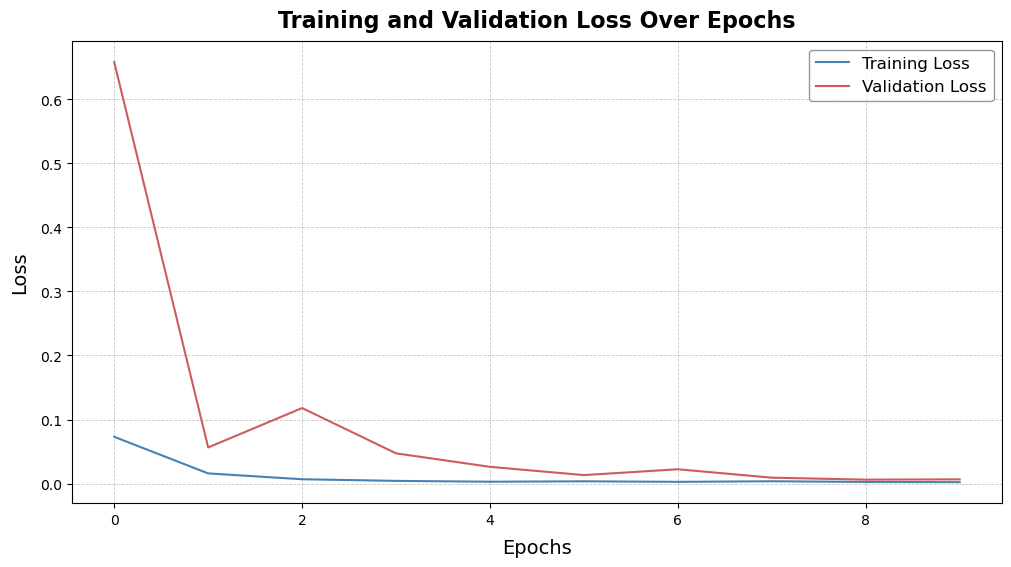

In [216]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='steelblue', lw=1.5)
plt.plot(val_losses, label='Validation Loss', color='indianred', lw=1.5)
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold', pad=10)
plt.xlabel('Epochs', fontsize=14, labelpad=8)
plt.ylabel('Loss', fontsize=14, labelpad=8)
plt.grid(which='major', linestyle='--', lw=0.6, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper right')
plt.show()

In [217]:
# Testing and Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy())

y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

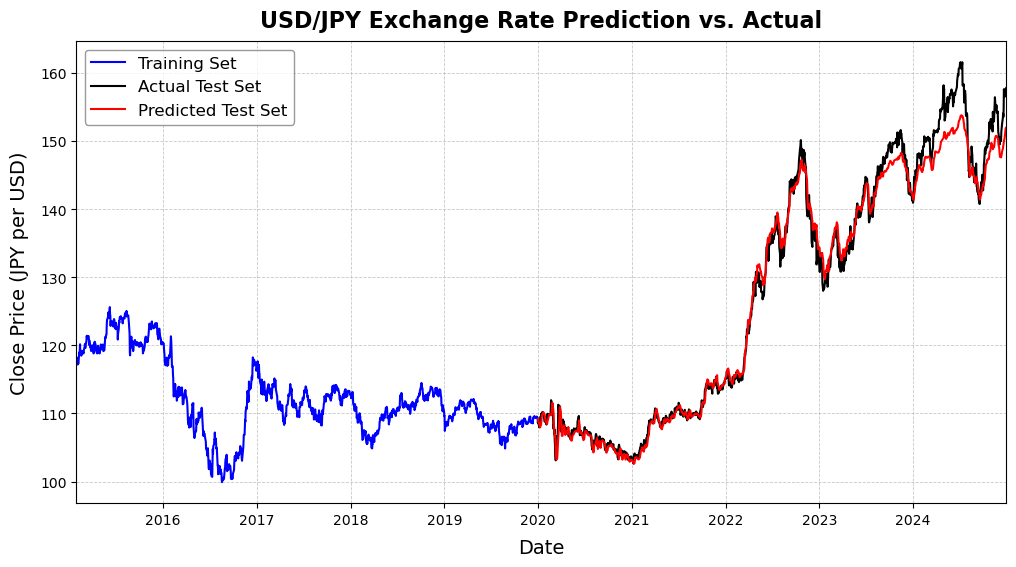

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'][:-test_size], yen.Close[:-test_size], label="Training Set", color='blue', lw=1.5)
plt.plot(yen['Date'].iloc[-test_size:], y_test_true, label="Actual Test Set", color='black', lw=1.5)
plt.plot(yen['Date'].iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='red', lw=1.5)
plt.title('USD/JPY Exchange Rate Prediction vs. Actual', fontsize=16, fontweight='bold', pad=10)
plt.xlabel('Date', fontsize=14, labelpad=8)
plt.ylabel('Close Price (JPY per USD)', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.6, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.show()

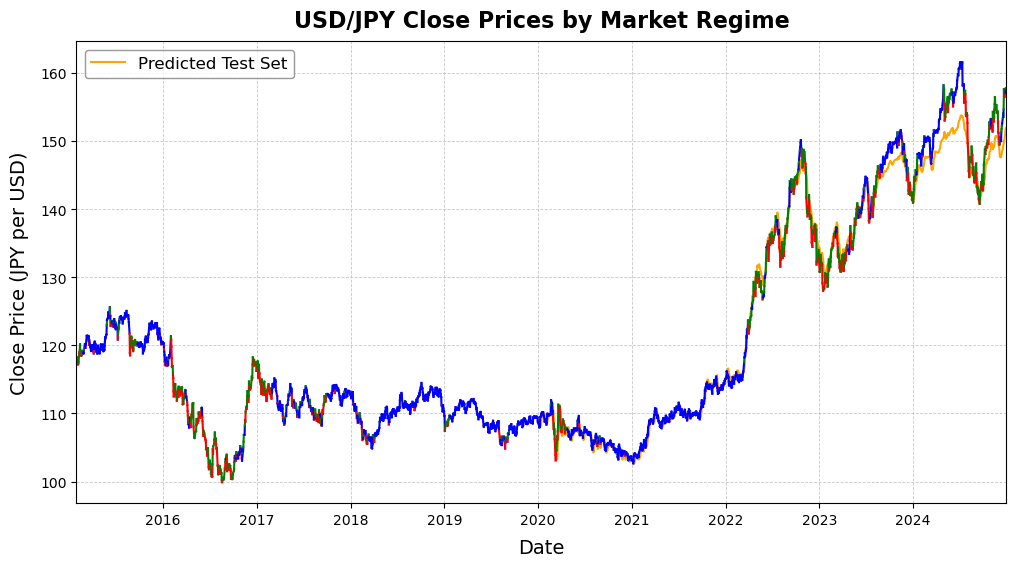

In [219]:
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))
plt.plot(yen['Date'].iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='orange', lw=1.5)
for i in range(1, len(yen.Close.values)):
    if yen['K Regime'].values[i] != yen['K Regime'].values[i-1]:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i-1]], lw=1.5)
    else:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], color=colors[yen['K Regime'].values[i]], lw=1.5)
plt.title('USD/JPY Close Prices by Market Regime', fontsize=16, fontweight='bold', pad=10)
plt.xlabel('Date', fontsize=14, labelpad=8)
plt.ylabel('Close Price (JPY per USD)', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.6, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.show()

In [220]:
def test_model(model, X_test, y_test):
    model.eval()
    y_pred = model(torch.tensor(X_test).float().to(device))
    y_pred = y_pred.detach().cpu().numpy().flatten()
    
    test_loss = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    Accuracy = 1 - MAPE

    return y_pred, test_loss, MAPE, Accuracy

y_test_pred1, test_loss, MAPE, Accuracy = test_model(model, X_test, y_test)

print(f"Test Loss (MAE): {test_loss:.4f}")
print(f"Test MAPE: {MAPE:.4f}")
print(f"Test Accuracy: {Accuracy:.4f}")

Test Loss (MAE): 0.0554
Test MAPE: 0.0585
Test Accuracy: 0.9415


## Algorithmic Trading

Now that we have the predicted values, we can perform algorithmic trading.